<a href="https://colab.research.google.com/github/dauparas/tensorflow2_ipynb/blob/master/BERT_for_protein_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import dependencies { display-mode: "form" }

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
from keras.layers import Input, Embedding, LSTM, Dense

import pandas as pd
from scipy.sparse import csr_matrix
import umap
from sklearn.metrics.cluster import adjusted_rand_score

import h5py
#Step 1: import dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from __future__ import division
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
import keras.backend as K
import os
import random

%matplotlib inline
plt.style.use('dark_background')

TensorFlow 2.x selected.


Using TensorFlow backend.


# Load data

## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''one hot encode msa'''
  
  ################
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  ################
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, tf.keras.utils.to_categorical(msa_ori,states)

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/1BXYA.fas

In [4]:
names,seqs = parse_fasta("1BXYA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(2025, 60)
(2025, 60, 21)


In [5]:
len("ARNDCQEGHILKMFPSTWYV-")

21

In [0]:
def new_mask(msa_ori, p=0.95):
  mask_inpt = np.random.binomial(1, p, size=msa_ori.shape)
  indx = np.argwhere(mask_inpt == 0)
  rand_indx = indx[np.random.choice(indx.shape[0], indx.shape[0], replace=False),:]
  masked_msa_inpt = np.copy(msa_ori)
  for i in range(indx.shape[0]):
    if i < np.int(indx.shape[0]*0.8):
      i1, i2 = rand_indx[i,:]
      masked_msa_inpt[i1, i2] = 21
    elif np.int(indx.shape[0]*0.8) <= i < np.int(indx.shape[0]*0.9):
      i1, i2 = rand_indx[i,:]
      masked_msa_inpt[i1, i2] = np.random.randint(21)
      
  return msa_ori, masked_msa_inpt, mask_inpt

In [0]:
MSA, MSA_MASKED, MASK = new_mask(msa_ori, p=0.95)
batch_size = 32
train_dataset = (msa_ori, MASK.astype(np.float32), MSA_MASKED)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(batch_size)

In [11]:
train_dataset

<BatchDataset shapes: ((None, 60), (None, 60), (None, 60)), types: (tf.int64, tf.float32, tf.int64)>

# Transformer model

Based on:
https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/text/transformer.ipynb


# Attention layer

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model): #position = length of seq
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
def scaled_dot_product_attention(q, k, v, mask=None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, attention_weights = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2, attention_weights

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    #x = tf.one_hot(x, depth=self.d_model, axis=-1)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x, attn_weights = self.enc_layers[i](x, training, mask)
      
    
    return x, attn_weights  # (batch_size, input_seq_len, d_model)

In [0]:
optimizer = tf.keras.optimizers.Adam(3e-4)

In [0]:
sample_encoder = Encoder(6, 100, 10, 100*4, 60)
final_layer = tf.keras.layers.Dense(22, name='fO')

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(MSA, MASK, MSA_MASKED):
    with tf.GradientTape() as tape:
      Z, attn_weights= sample_encoder(MSA_MASKED, training=True, mask=None)
      O = final_layer(Z, training=True)
      H = tf.nn.softmax_cross_entropy_with_logits(labels = tf.one_hot(MSA, 22, axis=-1), logits=O,  axis=-1)
      ECE = tf.reduce_mean(tf.exp(H))
      l1 = H*(1-MASK)
      loss = tf.reduce_sum(l1)
      correct = tf.equal(tf.argmax(tf.nn.softmax(O, axis=-1), -1), MSA)
      correct = tf.cast(correct, tf.float32)
      accuracy = tf.reduce_mean(correct)

    gradients = tape.gradient(loss, sample_encoder.trainable_variables+final_layer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, sample_encoder.trainable_variables+final_layer.trainable_variables))
    return loss, accuracy, ECE

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for MSA, MASK, MSA_MASKED in dataset:
      loss, accuracy, ECE = train_step(MSA, MASK, MSA_MASKED)
    print('Loss: {0:.3f}, Accuracy: {1:.3f}, ECE: {2:.3f}'.format(loss.numpy(), accuracy.numpy(), ECE.numpy()))
  return None

In [65]:
%%time
for i in range(100):

  MSA, MSA_MASKED, MASK = new_mask(msa_ori, p=0.85)
  batch_size = 32
  train_dataset = (msa_ori, MASK.astype(np.float32), MSA_MASKED)
  train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
  train_dataset = train_dataset.shuffle(buffer_size=10000)
  train_dataset = train_dataset.batch(batch_size)
  
  train(train_dataset, 5)

Loss: 286.369, Accuracy: 0.106, ECE: 20.184
Loss: 254.011, Accuracy: 0.102, ECE: 21.263
Loss: 273.981, Accuracy: 0.100, ECE: 22.832
Loss: 204.305, Accuracy: 0.083, ECE: 20.068
Loss: 217.799, Accuracy: 0.124, ECE: 19.937
Loss: 221.586, Accuracy: 0.102, ECE: 19.228
Loss: 222.948, Accuracy: 0.104, ECE: 22.053
Loss: 224.768, Accuracy: 0.087, ECE: 23.574
Loss: 214.475, Accuracy: 0.106, ECE: 26.328
Loss: 190.273, Accuracy: 0.120, ECE: 18.952
Loss: 256.411, Accuracy: 0.106, ECE: 23.358
Loss: 231.507, Accuracy: 0.107, ECE: 23.047
Loss: 202.638, Accuracy: 0.109, ECE: 19.394
Loss: 237.967, Accuracy: 0.100, ECE: 19.881
Loss: 257.294, Accuracy: 0.133, ECE: 21.478
Loss: 258.269, Accuracy: 0.100, ECE: 22.506
Loss: 221.815, Accuracy: 0.094, ECE: 24.570
Loss: 245.861, Accuracy: 0.109, ECE: 19.651
Loss: 228.899, Accuracy: 0.113, ECE: 18.795
Loss: 232.342, Accuracy: 0.122, ECE: 18.623
Loss: 201.864, Accuracy: 0.120, ECE: 22.620
Loss: 224.761, Accuracy: 0.106, ECE: 19.667
Loss: 190.852, Accuracy: 0.117, 

In [0]:
C = np.zeros(22)
C[0] = 0 # A - Alanine - Ala -> hydrophobic side chain = 0
C[1] = 1 # R - Arginine - Arg -> positively charged = 1
C[2] = 2 # N - Asparagine - Asn -> polar uncharged = 2
C[3] = 3 # D - Aspartic Acid - Asp -> negatively charged = 3
C[4] = 4 # C - Cysteine - Cys -> special cases = 4
C[5] = 2 # Q - Glutamine - Gln -> polar uncharged = 2
C[6] = 3 # E - Glatamic Acid - Glu -> negatively charged = 3
C[7] = 4 # G - Glycine - Gly -> special cases = 4
C[8] = 1 # H - Histidine - His -> positively charged = 1
C[9] = 0 # I - Isoleucine - Ile -> hydrophobic side chain = 0
C[10] = 0 # L - Leucine - Leu -> hydrophobic side chain = 0
C[11] = 1 # K - Lysine - Lys -> positively charged = 1
C[12] = 0 # M - Methionine - Met -> hydrophobic side chain = 0
C[13] = 0 # F - Phenylalanine - Phe -> hydrophobic side chain = 0
C[14] = 4 # P - Proline - Pro -> special cases = 4
C[15] = 2 # S - Serine - Ser -> polar uncharged = 2
C[16] = 2 # T - Threonine - Thr -> polar uncharged = 2
C[17] = 0 # W - Tryptophan - Trp -> hydrophobic side chain = 0
C[18] = 0 # Y - Tyrosine - Tyr -> hydrophobic side chain = 0
C[19] = 0 # V - Valine - Val -> hydrophobic side chain = 0
C[20] = 5 # - gaps
C[21] = 5 # * masks

In [0]:
W = final_layer.weights[0].numpy()

In [0]:
W_embedded = umap.UMAP(
    n_neighbors=3,
    min_dist=0.05,
    n_components=2,
    random_state=0,
).fit_transform(W.T)

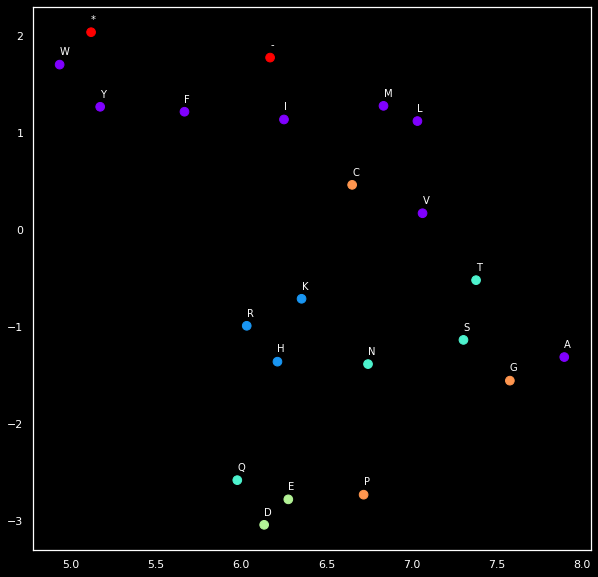

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(W_embedded[:,0], W_embedded[:,1], c=C, s=75.0*np.ones(22), cmap='rainbow')
ax.grid(None)


k=0
for i in "ARNDCQEGHILKMFPSTWYV-*":
  ax.annotate(i, (W_embedded[k,0], W_embedded[k,1]+0.1))
  k += 1